<a href="https://colab.research.google.com/github/md-pras/Prediksi-Usia-menggunakan-CNN-Snapshot-Ensemble/blob/main/Prediksi_Usia_menggunakan_CNN_Snapshot_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b> Prediksi Usia menggunakan CNN Snapshot Ensemble </b></h1></center>

---
<font color='red'>
  * catatan: <br>
  1. Notebook ini dikerjakan menggunakan Google Colab. <br>
  2. Autentifikasi akun Google diperlukan untuk download dataset dari Google Drive secara langsung.
</font>


## A. Preparasi Data

### 1. Import package yang diperlukan

In [ ]:
!pip install mtcnn-opencv

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


In [ ]:
# Load packages

import os
import glob
import requests 
import shutil 
import math
from math import pi, cos, floor
import numpy as np
import pandas as pd
import time
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras import backend

from mtcnn_cv2 import MTCNN

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from lightgbm import LGBMRegressor, Booster

### 2. Download dataset dari Google Drive
Data yang digunakan pada notebook ini tersedia pada https://ipb.link/data-bdc-2021 yang terdiri dari dua folder, yaitu Training dan Testing dan dua file csv yaitu train.csv dan submission.csv.

![](https://drive.google.com/uc?export=view&id=1-qvvfeGp_Seb46--V-yF11ZgQOf2-QZj)


#### a. Autentifikasi akun Google Drive

In [ ]:
#Autentifikasi Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#### b. Membuat direktori
Membuat direktori yang diperlukan untuk menyimpan dataset. Struktur direktori yang digunakan adalah sebagai berikut:
```
.
└── Data
    ├── Training
    │   ├── 1
    │   ├── 2
    │   ├── 3
    │   └── ...
    │   
    ├── Testing
    │   ├── 1
    │   ├── 2
    │   ├── 3
    │   └── ...
    │ 
    ├── train.csv
    └── submission.csv
```



In [ ]:
# Membuat directory
if not os.path.exists('/Data'):
    os.mkdir('/Data')
if not os.path.exists('/Data/Training'):
    os.mkdir('/Data/Training')
if not os.path.exists('/Data/Testing'):
    os.mkdir('/Data/Testing')
if not os.path.exists('/content'):
    os.mkdir('/content')

#### c. Download data training
Data training berasal dari Google Drive yang dapat diakses melalui https://drive.google.com/drive/folders/1eEVRizmsqV_f7pWOCAvNrTegMCEiabXr

In [ ]:
# ID folder Google Drive
drive_id = '1eEVRizmsqV_f7pWOCAvNrTegMCEiabXr'

# Download data dari ID folder Google Drive
def get_training_data(parent):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(drive_id)}).GetList()
  
  for f in file_list:
    if not os.path.exists('/Data/Training/' + f['title']):
      os.mkdir('/Data/Training/' + f['title'])

    file_list2 = drive.ListFile({'q': "'{}' in parents and trashed=false".format(f['id'])}).GetList()

    for g in file_list2:
      g.GetContentFile(os.path.join('/Data/Training', f['title'], g['title']))

get_training_data('root')

#### d. Download data testing
Data testing berasal dari Google Drive yang dapat diakses melalui https://drive.google.com/drive/folders/19ngUX7KOLW59UPlFFWS5iMXkWEOCgFQw

In [ ]:
# ID folder Google Drive
drive_id = '19ngUX7KOLW59UPlFFWS5iMXkWEOCgFQw'

# Download data dari ID folder Google Drive
def get_testing_data(parent):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(drive_id)}).GetList()
  
  for f in file_list:
      f.GetContentFile(os.path.join('/Data/Testing', f['title']))

get_testing_data('root')

#### e. Download data train.csv
Data train.csv berasal dari Google Drive yang dapat diakses melalui https://drive.google.com/file/d/1Px2jr9tUxico2zxSx4tgjaR1PWUJAD6W/view?usp=sharing

In [ ]:
train_csv = drive.CreateFile({'id': '1Px2jr9tUxico2zxSx4tgjaR1PWUJAD6W'})
train_csv.GetContentFile('/Data/train.csv')

#### f. Download data submission.csv
Data submission.csv berasal dari Google Drive yang dapat diakses melalui https://drive.google.com/file/d/1Ev9jmZQjprLRv1ZoAkB4hm1H7mbhfEUb/view?usp=sharing

In [ ]:
submission_csv = drive.CreateFile({'id': '1Ev9jmZQjprLRv1ZoAkB4hm1H7mbhfEUb'})
submission_csv.GetContentFile('/Data/submission.csv')

## B. Exploratory Data Analysis

### 1. Preview gambar

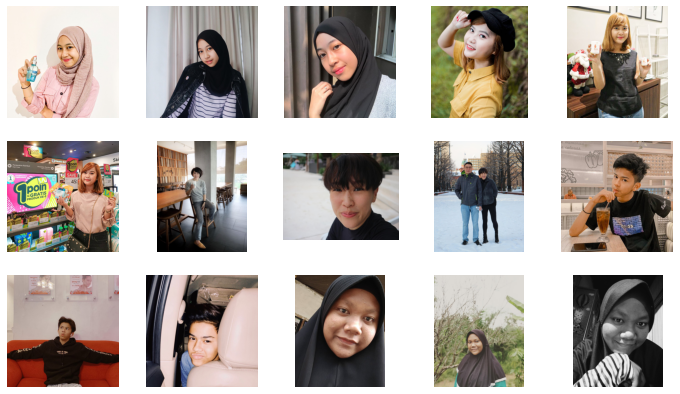

In [ ]:
# Preview gambar data training
file_path = glob.glob('/Data/Training/**/*.jpg')

plt.figure(figsize=(12,7))
for i in range(15):
  plt.subplot(3,5,i+1)
  img = plt.imread(file_path[i])
  plt.imshow(img)
  plt.axis('off')
plt.show()

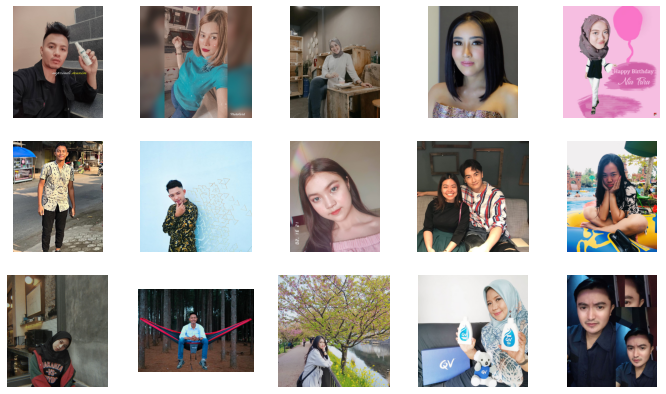

In [ ]:
# Preview gambar data testing
test_file_path = glob.glob('/Data/Testing/*.jpg')

plt.figure(figsize=(12,7))
for i in range(15):
  plt.subplot(3,5,i+1)
  img = plt.imread(test_file_path[i])
  plt.imshow(img)
  plt.axis('off')
plt.show()

### 2. Preview data CSV

In [ ]:
# Preview data train.csv
df = pd.read_csv('/Data/train.csv')
df.head(n=6)

,nomor,jenis kelamin,usia
0,1,0,27
1,2,1,24
2,3,0,29
3,4,1,23
4,5,0,20
5,6,1,28


In [ ]:
# Preview data submission.csv
df1 = pd.read_csv('/Data/submission.csv')
df1.head(n=6)

,id,usia
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27,NaN
1,0052554e-069e-4c43-beb0-0885e8f7684e,NaN
2,0092b954-1143-4a95-a17b-1edfa6af3b01,NaN
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16,NaN
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810,NaN
5,00f7b619-513e-4e43-bc32-ec49d233e09e,NaN


### 3. Statistik deskriptif


In [ ]:
# Tabel statistik deskriptif dari variabel usia pada data Training
pd.DataFrame({'': df['usia'].describe()})

,
count,770.000000
mean,26.098701
std,5.294266
min,5.000000
25%,23.000000
50%,26.000000
75%,28.000000
max,50.000000


In [ ]:
# Jumlah gambar pada data
print('Jumlah gambar pada data Training: ', len(file_path))
print('Jumlah gambar pada data Testing: ', len(test_file_path))

Jumlah gambar pada data Training:  2310
Jumlah gambar pada data Testing:  990


In [ ]:
# Missing value pada data Training
pd.DataFrame({'Jumlah missing value': df.isna().sum()})

,Jumlah missing value
nomor,0
jenis kelamin,0
usia,0


### 4. Distribusi/sebaran data
Grafik distribusi/sebaran variabel usia pada data training

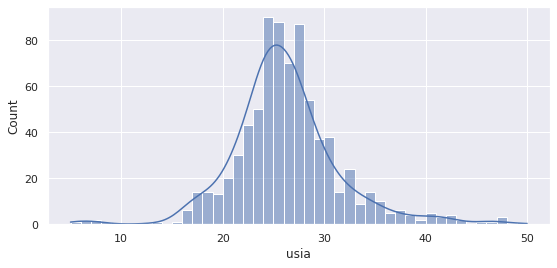

In [ ]:
sns.set(rc = {'figure.figsize':(9,4)})
sns.histplot(x=df['usia'], bins=45, kde = True)

## C. Data Preprocessing

### 1. Ekstraksi wajah pada data training

In [ ]:
# function untuk ekstraksi wajah data training
def extract_face(filename, required_size=(180, 180)):
    image = cv2.imread(filename)
    pixels = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    # Membuat detector MTCN
    detector = MTCNN()
    results = detector.detect_faces(pixels)

    # Bounding box wajah
    if len(results) != 0:
      heights = [n['box'][3] for n in results]
      max_heights = np.argmax(heights)
    
      x1, y1, width, height = results[max_heights]['box']
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      face = pixels[y1:y2, x1:x2]
 
    # Kondisi jika terdeteksi 1 atau lebih dari 2 wajah
    if (len(results) == 1) or (len(results) > 2):     
      face_array = cv2.resize(face, required_size, interpolation=cv2.INTER_AREA)
    
    # Kondisi jika terdeteksi 2 wajah
    elif len(results) == 2:
      h0, h1 = min(heights), max(heights)
      if h1/h0 > 0.7:
        face_array = np.zeros((180, 180,3), dtype='uint8')
      else:
        face_array = cv2.resize(face, required_size, interpolation=cv2.INTER_AREA)

    # Kondisi jika tidak terdeteksi wajah
    else:
      face_array = np.zeros((180, 180,3), dtype='uint8')
     
    return face_array

In [ ]:
# Ekstraksi wajah dari gambar data training
training_data = []

start_time = time.time()

for path in file_path:
  nomor = os.path.basename(os.path.dirname(path))
  face = extract_face(path)
  if (face == np.zeros((180,180,3))).all():
    continue
  else:
    training_data.append([face, nomor])

end_time = time.time()-start_time

# Print alokasi waktu
print('elapsed time: {} sec = {} min'.format(round(end_time, 2), round(end_time/60, 2)))

elapsed time: 1294.67 sec = 21.58 min


In [ ]:
# Menyimpan hasil ekstraksi dalam bentuk X dan y
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X, dtype='uint8').reshape(-1, 180, 180, 3)

In [ ]:
df2 = pd.DataFrame({'nomor':y})
df2['nomor'] = df2['nomor'].astype('int32')
df2 = pd.merge(df2, df, on='nomor')
y = np.array(df2['usia'])

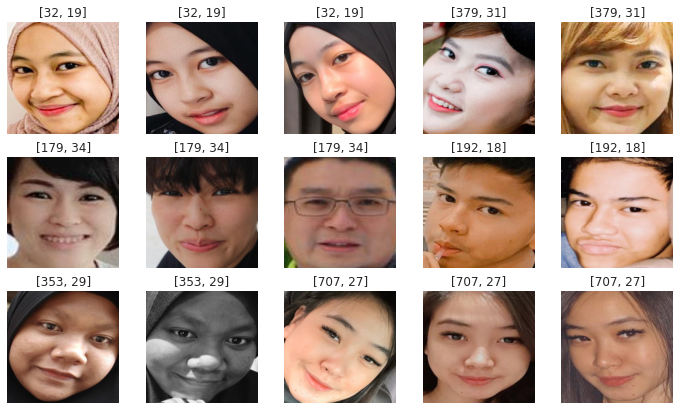

In [ ]:
# Preview hasil ekstraksi wajah
plt.figure(figsize=(12,7))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(X[i])
  plt.title([df2['nomor'][i], df2['usia'][i]])
  plt.axis('off')

plt.show()

In [ ]:
# Backup hasil ekstraksi ke Google Drive
# Uncomment code dibawah ini jika ingin backup ke Google Drive

#from google.colab import drive
#drive.mount('/content/drive')

#np.save('/content/drive/MyDrive/X.npy',X)
#np.save('/content/drive/MyDrive/y.npy',y)

### 2. Ekstraksi wajah pada data testing

In [ ]:
# function untuk ekstraksi wajah data testing
def extract_face_test(filename, required_size=(180, 180)):
    image = cv2.imread(filename)
    pixels = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    # Membuat detector MTCN
    detector = MTCNN()
    results = detector.detect_faces(pixels)

    # Kondisi jika terdeteksi wajah
    if len(results) > 0:
      heights = [n['box'][3] for n in results]
      max_heights = np.argmax(heights)
    
      x1, y1, width, height = results[max_heights]['box']
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      face = pixels[y1:y2, x1:x2]

      face_array = cv2.resize(face, required_size, interpolation=cv2.INTER_AREA)

    # Kondisi jika tidak terdeteksi wajah
    else:
      face_array = np.zeros((180, 180,3), dtype='uint8')
     
    return face_array

In [ ]:
# Ekstraksi wajah dari gambar data testing
test_file_path = glob.glob('/Data/Testing/*.jpg')
testing_data = []

start_time = time.time()

for path in test_file_path:
  id = os.path.basename(path)
  face = extract_face_test(path)
  testing_data.append([face, id])

end_time = time.time()-start_time

# Print alokasi waktu
print('elapsed time: {} sec = {} min'.format(round(end_time, 2), round(end_time/60, 2)))

elapsed time: 545.18 sec = 9.09 min


In [ ]:
# Menyimpan hasil ekstraksi dalam bentuk X_test dan id_test
X_test = []
id_test = []

for features, label in testing_data:
    X_test.append(features)
    id_test.append(label)
    
X_test = np.array(X_test).reshape(-1, 180, 180, 3)
id_test = np.array(id_test)

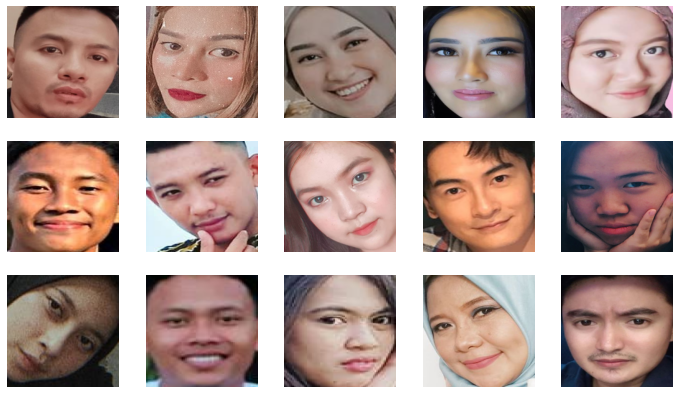

In [ ]:
# Preview hasil ekstraksi wajah
plt.figure(figsize=(12,7))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(X_test[i])
  plt.axis('off')

plt.show()

In [ ]:
# Backup hasil ekstraksi ke Google Drive
# Uncomment code dibawah ini jika ingin backup ke Google Drive

#np.save('/content/drive/MyDrive/X_test.npy',X_test)
#np.save('/content/drive/MyDrive/id_test.npy',id_test)

### 3. Split data
Membagi data Training menjadi data train dan data validation ((X_train, y_train) dan (X_val, y_val)). Proporsi data train sebesar 80%. Sedangkan proporsi data validation sebesar 20%.

![](https://drive.google.com/uc?export=view&id=1KBF280EcFvKcmMSg8N0GYygSThkVJXiu)


In [ ]:
X = X.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### 4. Augmentasi gambar

Menerapkan augmentasi gambar dengan:
* resacle gambar dari skala [0, 255] ke dalam skala [0, 1]
* random rotation sebesar 20 derajat
* random brightness dengan skala [0.9, 1.1] 
* random zoom sebesar [0.85, 1.05]
* random horizontal flip (p = 0.5)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 20, 
                                   #width_shift_range = 0.1, 
                                   #height_shift_range = 0.1, 
                                   brightness_range = [0.9,1.1], 
                                   #shear_range = 10, 
                                   zoom_range = [0.85, 1.05], 
                                   #channel_shift_range = 10.0,
                                   horizontal_flip = True,
                                   fill_mode = 'constant')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y=y_train, 
                                     batch_size=32 , seed=25,
                                     shuffle=False)

val_generator = test_datagen.flow(X_val, y=y_val,
                                   batch_size=32, seed=25,
                                   shuffle=False)

test_generator = test_datagen.flow(X_test, y=None,
                                   batch_size=32, seed=25,
                                   shuffle=False)

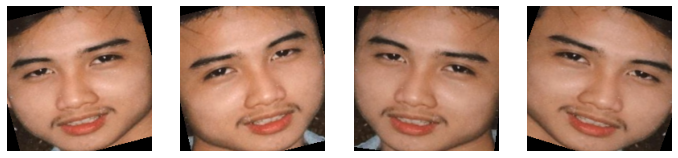

In [ ]:
# Preview hasil augmentasi pada sampel gambar
plt.figure(figsize=(15,10))
for i in range(4):
  plt.subplot(1,5,i+1)
  batch = train_generator[0]
  image = batch[0][5]
  plt.imshow(image)
  plt.axis('off')

plt.show()

## D. Pemodelan

### 1. Arsitektur CNN
Model yang digunakan adalah model Convolutional Neural Network (CNN) dengan menambahkan:
* Layer batch normalization
* Layer max pool 2x2
* Layer dropout

In [ ]:
# Network architecture

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same',input_shape=(X.shape[1:])))
model.add(BatchNormalization(momentum=0.01))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization(momentum=0.01))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization(momentum=0.01))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization(momentum=0.01))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization(momentum=0.01))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization(momentum=0.01))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization(momentum=0.01))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

#model.summary()

### 2. Plot arsitektur network

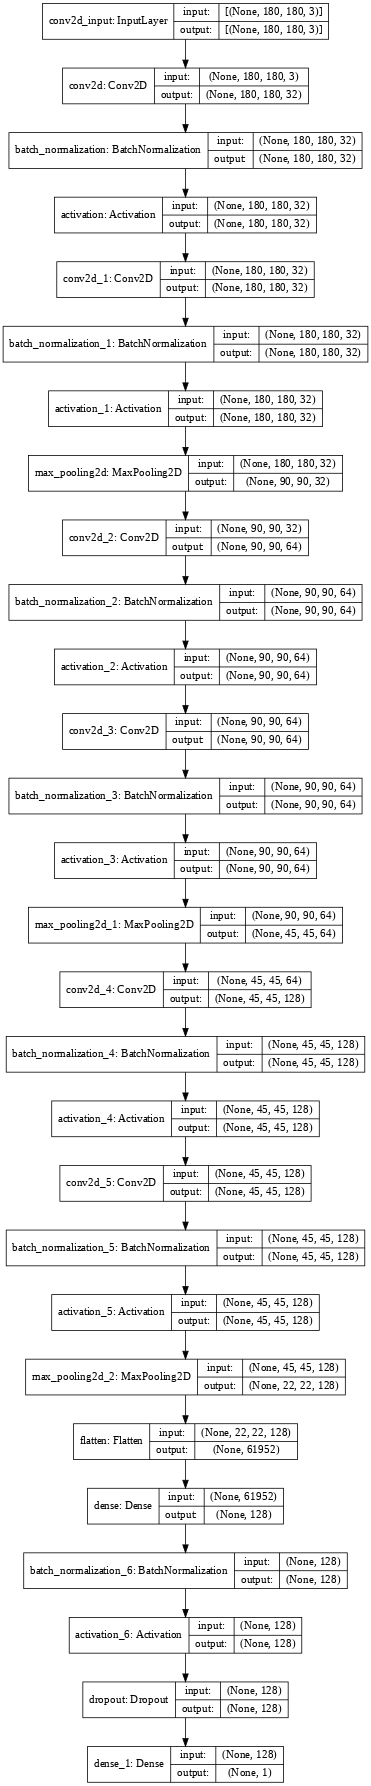

In [ ]:
# Plot arsitektur network
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, 
    show_layer_names=True, expand_nested=False, dpi=56,
    layer_range=None
)

### 3. Compile model
Compile model dengan:

* optimizer = Stochastic Gradient Descent (SGD)
* momentum = 0.9
* learning rate = - (learning rate schedule)
* loss function = Mean Square Error (MSE)

In [ ]:
# Compile model
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics = ['mae'])

### 4. Callback

#### a. Snapshot ensemble callback
Menyimpan (snapshot) model berdasarkan cyclic learning rate schedule menggunakan fungsi cosine annealing. Model akan disimpan jika learning rate mencapai titik terendah. 
* Banyaknya model yang disimpan (n_cycles) = 5
* Banyaknya epoch (n_epoch) = 50
* Max learning rate = 0.001
* Min learning rate = 0.0005

In [ ]:
n_epochs = 50
n_cycles = 5
lrate_max = 0.001

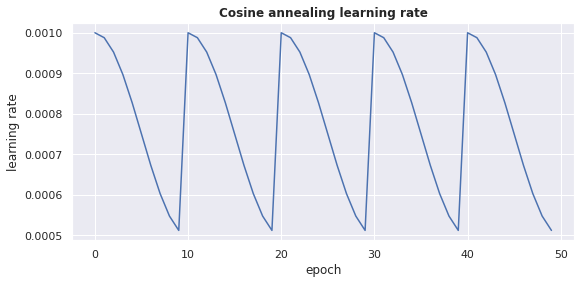

In [ ]:
# cosine annealing learning rate schedule
def cosine_annealing(epoch, n_epochs, n_cycles, lrate_max):
	epochs_per_cycle = floor(n_epochs/n_cycles)
	cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
	return (lrate_max/2 * (cos(cos_inner) + 1)) + 0.0005
 
series = [cosine_annealing(i, n_epochs, n_cycles, lrate_max-0.0005) for i in range(n_epochs)]
# plot series
plt.plot(series)
plt.title('Cosine annealing learning rate', fontweight='bold')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

In [ ]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()
 
	# calculate learning rate for epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return (lrate_max/2 * (cos(cos_inner) + 1)) + 0.0005
 
	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs={}):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)
 
	# save models at the end of each cycle
	def on_epoch_end(self, epoch, logs={}):
		# check if we can save model
		epochs_per_cycle = floor(self.epochs / self.cycles)
		if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
			# save model to file
			filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
			self.model.save(filename)
			print('>saved snapshot %s, epoch %d' % (filename, epoch))

In [ ]:
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.0005)

#### b. Model checkpoint callback
Model checkpoint callback digunakan untuk menyimpan model dengan validation loss (MSE) terkecil.

In [ ]:
# Model checkpoint
checkpoint = ModelCheckpoint('/content/model_checkpoint1.h5', 
                             monitor = 'val_loss',
                             mode = 'min',
                             save_best_only = True)

### 5. Fit model

In [ ]:
# Model fit
history = model.fit(train_generator,
          validation_data = val_generator,
          batch_size = 32,
          verbose = 1,
          callbacks = [checkpoint, ca],
          epochs = n_epochs)

Epoch 1/50
49/49 [==============================] - 52s 391ms/step - loss: 132.9559 - mae: 8.5681 - val_loss: 41.2503 - val_mae: 4.8264
Epoch 2/50
49/49 [==============================] - 18s 372ms/step - loss: 42.2470 - mae: 4.9561 - val_loss: 34.0839 - val_mae: 4.3611
Epoch 3/50
49/49 [==============================] - 18s 371ms/step - loss: 40.4741 - mae: 4.7897 - val_loss: 28.6854 - val_mae: 3.9110
Epoch 4/50
49/49 [==============================] - 18s 371ms/step - loss: 37.4627 - mae: 4.6175 - val_loss: 38.2530 - val_mae: 4.6377
Epoch 5/50
49/49 [==============================] - 18s 373ms/step - loss: 34.9448 - mae: 4.4458 - val_loss: 27.5144 - val_mae: 3.7088
Epoch 6/50
49/49 [==============================] - 18s 374ms/step - loss: 32.0678 - mae: 4.1843 - val_loss: 27.9179 - val_mae: 3.8532
Epoch 7/50
49/49 [==============================] - 18s 373ms/step - loss: 32.0481 - mae: 4.2404 - val_loss: 28.3922 - val_mae: 3.8087
Epoch 8/50
49/49 [==============================] - 18

In [ ]:
# Backup model yang tersimpan ke Google Drive
# Uncomment code dibawah ini jika ingin backup ke Google Drive

#!zip '/content/saved_model.zip' '/content/model_checkpoint1.h5' '/content/snapshot_model_1.h5' '/content/snapshot_model_2.h5' '/content/snapshot_model_3.h5' '/content/snapshot_model_4.h5' '/content/snapshot_model_5.h5'
#!cp '/content/saved_model.zip' '/content/drive/MyDrive/saved_age_modeln.zip'

## E. Evaluasi model

### 1. Plot model history

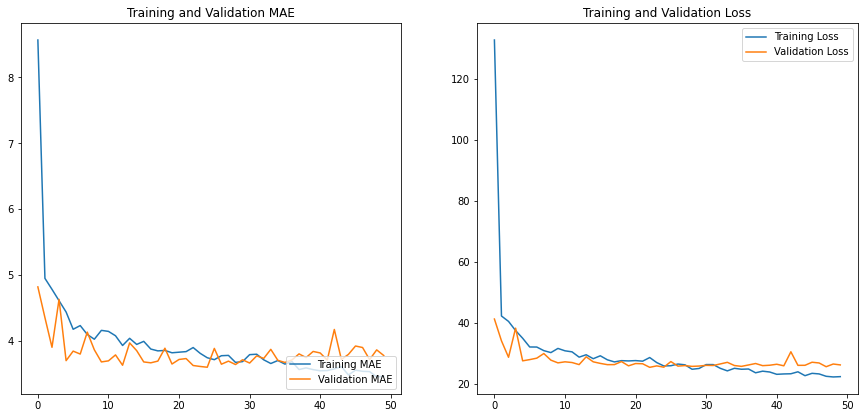

In [ ]:
# Plot model
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2. Prediksi dari model yang tersimpan
Prediksi dari 6 model yang tersimpan (5 snapshot model & 1 checkpoint model) pada data train dan data validation

In [ ]:
# Uncomment code dibawah ini jika ingin restore model dari Google Drive

# !cp '/content/drive/MyDrive/saved_age_modeln.zip' '/content/saved_model.zip'
# !unzip '/content/saved_modeln.zip' -d '/'

In [ ]:
# Load snapshot models
snapshot1 = keras.models.load_model('/content/snapshot_model_1.h5')
snapshot2 = keras.models.load_model('/content/snapshot_model_2.h5')
snapshot3 = keras.models.load_model('/content/snapshot_model_3.h5')
snapshot4 = keras.models.load_model('/content/snapshot_model_4.h5')
snapshot5 = keras.models.load_model('/content/snapshot_model_5.h5')

# Load checkpoint model
checkpoint = keras.models.load_model('/content/model_checkpoint1.h5')

In [ ]:
# Extract meta features dari snapshot model & checkpoint model

X_train_meta = pd.DataFrame({
  'X1': snapshot1.predict(train_generator).reshape(-1),
  'X2': snapshot2.predict(train_generator).reshape(-1),
  'X3': snapshot3.predict(train_generator).reshape(-1),
  'X4': snapshot4.predict(train_generator).reshape(-1),
  'X5': snapshot5.predict(train_generator).reshape(-1),
  'X6': checkpoint.predict(train_generator).reshape(-1)
  })

X_val_meta = pd.DataFrame({
  'X1': snapshot1.predict(val_generator).reshape(-1),
  'X2': snapshot2.predict(val_generator).reshape(-1),
  'X3': snapshot3.predict(val_generator).reshape(-1),
  'X4': snapshot4.predict(val_generator).reshape(-1),
  'X5': snapshot5.predict(val_generator).reshape(-1),
  'X6': checkpoint.predict(val_generator).reshape(-1)
  })

X_test_meta = pd.DataFrame({
  'X1': snapshot1.predict(test_generator).reshape(-1),
  'X2': snapshot2.predict(test_generator).reshape(-1),
  'X3': snapshot3.predict(test_generator).reshape(-1),
  'X4': snapshot4.predict(test_generator).reshape(-1),
  'X5': snapshot5.predict(test_generator).reshape(-1),
  'X6': checkpoint.predict(test_generator).reshape(-1)
  })

In [ ]:
# Backup meta features ke Google Drive
# Uncomment code dibawah ini jika ingin backup ke Google Drive

#pd.DataFrame.to_csv(X_train_meta, '/content/drive/MyDrive/X_train_meta.csv', index=False)
#pd.DataFrame.to_csv(X_val_meta, '/content/drive/MyDrive/X_val_meta.csv', index=False)
#pd.DataFrame.to_csv(X_test_meta, '/content/drive/MyDrive/X_test_meta.csv', index=False)

# Restore meta features dari Google Drive
# Uncomment code dibawah ini jika ingin restore dari Google Drive

#X_train_meta = pd.read_csv('/content/drive/MyDrive/X_train_meta.csv')
#X_val_meta = pd.read_csv('/content/drive/MyDrive/X_val_meta.csv')
#X_test_meta = pd.read_csv('/content/drive/MyDrive/X_test_meta.csv')

In [ ]:
# Preview data X_train_meta
X_train_meta.head()

,X1,X2,X3,X4,X5,X6
0,24.091473,26.242150,26.789207,27.832981,26.081700,25.674923
1,25.875439,25.051388,26.038342,26.520464,25.083984,27.068472
2,23.888674,26.629059,25.151810,24.347118,24.949547,24.891764
3,25.249150,23.792890,24.817413,23.239902,25.155537,25.104193
4,30.522114,26.774960,29.004990,29.194033,27.644580,25.251842


In [ ]:
# Print MSE tiap model pada data train
for i in range(6):
  print('MSE model {} : {}'.format(i+1, metrics.mean_squared_error(y_train, X_train_meta.iloc[:,i]).round(2)))

MSE model 1 : 25.45
MSE model 2 : 23.45
MSE model 3 : 22.76
MSE model 4 : 20.87
MSE model 5 : 20.32
MSE model 6 : 23.35


In [ ]:
# Print MSE tiap model pada data validation
for i in range(6):
  print('MSE model {} : {}'.format(i+1, metrics.mean_squared_error(y_val, X_val_meta.iloc[:,i]).round(2)))

MSE model 1 : 27.93
MSE model 2 : 26.92
MSE model 3 : 27.8
MSE model 4 : 27.03
MSE model 5 : 27.78
MSE model 6 : 26.03


## F. Snapshot Ensemble
Melakukan snapshot ensemble dengan sedikit modifikasi, yaitu dengan menambahkan model checkpoint. Ensemble yang digunakan berupa stacked ensemble. Base model yang digunakan adalah snapshot model dan checkpoint model yang dihasilkan dari model CNN. Sedangkan top model yang digunakan adalah model LightGBM.

![](https://drive.google.com/uc?export=view&id=1Vh3vEjICFHkn6uDQ549anJoCOLRl-l4L)


In [ ]:
# Estimator LightGBM
estimator = LGBMRegressor(random_state=42)

# LightGBM hyperparameters
parameters = {
  'max_depth' : [2,3], 
  'learning_rate' : [0.05, 0.01], 
  'n_estimators' : [20, 50, 100], 
  'subsample' : [0.9, 1.0],
  'max_bin' : [10,20,50],
  'colsample_bytree' : [0.9, 1.0],
  'reg_lambda' : [0.001, 0.01]
}

# Grid Search CV
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose=False
)

grid_search.fit(X_train_meta, y_train)

In [ ]:
# Fit LGBM 
lgbm = grid_search.best_estimator_
lgbm.fit(X=X_train_meta, y=y_train, verbose=0,
         eval_set = [(X_train_meta, y_train), (X_val_meta, y_val)],
         early_stopping_rounds = 20)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_bin=10,
              max_depth=2, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.001,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
# Prediksi
lgbm_train_pred = lgbm.predict(X_train_meta).round()
lgbm_val_pred = lgbm.predict(X_val_meta).round()

print('LightGBM train MSE: ', metrics.mean_squared_error(y_train, lgbm_train_pred))
print('LightGBM validation MSE: ', metrics.mean_squared_error(y_val, lgbm_val_pred))

LightGBM train MSE:  19.91580310880829
LightGBM validation MSE:  24.927648578811368


In [ ]:
# !cp 'lgbm_model.txt' '/content/drive/MyDrive/lgbm_model.txt'
# !cp '/content/drive/MyDrive/lgbm_model.txt' 'lgbm_model.txt'

In [ ]:
#lgbm.booster_.save_model('lgbm_model.txt')
#lgbm = Booster(model_file='lgbm_model.txt')

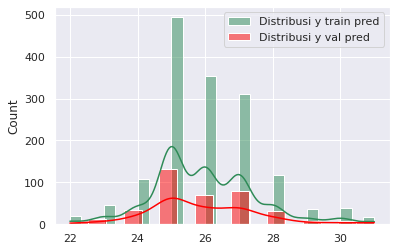

In [ ]:
# Distribusi usia hasil prediksi
sns.set(style="darkgrid")
sns.histplot(x=lgbm_train_pred.reshape(-1), kde=True, color='seagreen', label='Distribusi y train pred', legend=True)
sns.histplot(x=lgbm_val_pred.reshape(-1), kde=True, color='red', label='Distribusi y val pred', legend=True)
plt.legend()
plt.show()

## G. Prediksi Data Testing

### 1. Prediksi

In [ ]:
test_pred = lgbm.predict(X_test_meta).round()

In [ ]:
df2 = pd.DataFrame({'id': id_test, 'usia': test_pred})
df2 = df2.sort_values(by='id')
df2.head()

,id,usia
323,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27.jpg,24.0
354,0052554e-069e-4c43-beb0-0885e8f7684e.jpg,26.0
564,0092b954-1143-4a95-a17b-1edfa6af3b01.jpg,30.0
637,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16.jpg,24.0
231,00d0e306-06fe-45d8-ae6c-6f83ab8f7810.jpg,26.0


In [ ]:
df1['usia'] = np.array(df2['usia'].astype('int32'))
df1.head()

,id,usia
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27,24
1,0052554e-069e-4c43-beb0-0885e8f7684e,26
2,0092b954-1143-4a95-a17b-1edfa6af3b01,30
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16,24
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810,26


### 2. Preview hasil prediksi

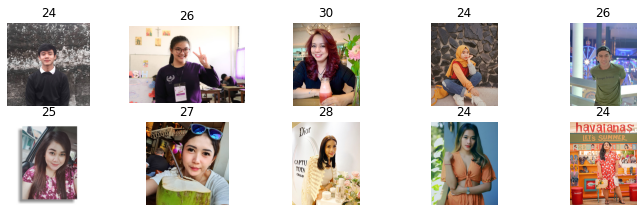

In [ ]:
# Preview testing data prediction
plt.figure(figsize=(12,7))
for i in range(10):
  plt.subplot(4,5,i+1)
  img_path = os.path.join('/tmp/Data/Testing', df1.id[i+0] + '.jpg')
  img = plt.imread(img_path)
  plt.imshow(img)
  plt.title(df1['usia'][i+0])
  plt.axis('off')

plt.show()

### 3. Distribusi usia

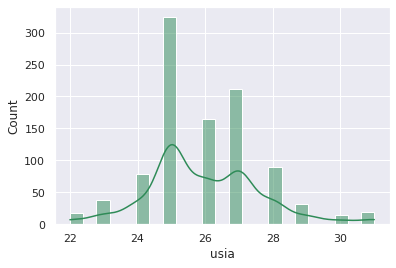

In [ ]:
# Distribusi usia pada data testing
sns.set(style="darkgrid")
sns.histplot(x=df1['usia'], kde=True, color='seagreen')
plt.show()

## H. Submission

In [ ]:
pd.DataFrame.to_csv(df1, '/content/submision.csv', index=False)

In [ ]:
# Backup to Google Drive
# pd.DataFrame.to_csv(df1, '/content/drive/MyDrive/submision_semifinal.csv', index=False)

## I. Penerapan pada Gambar Lain
Prediksi usia dari URL gambar di internet

In [ ]:
# Function prediksi usia
def age_predict(url):
  if os.path.exists('img_test.jpg'):
    os.remove('img_test.jpg')
  img_path = 'img_test.jpg'

  # Download gambar
  r = requests.get(url, stream = True)
  if r.status_code == 200:
    r.raw.decode_content = True
    with open(img_path,'wb') as f:
      shutil.copyfileobj(r.raw, f)        
  else:
    print('GAMBAR TIDAK DITEMUKAN')

  # Membaca gambar
  img_test = plt.imread(img_path)

  # Deteksi wajah
  detector = MTCNN()
  faces = detector.detect_faces(img_test)

  # Plot gambar
  plt.figure(figsize=(15,6))
  plt.subplot(1,2,1)
  plt.imshow(img_test)
  plt.title('Gambar asli')
  plt.subplot(1,2,2)
  plt.title('Estimasi usia')
  plt.imshow(img_test)
  ax = plt.gca()

  # Kondisi jika wajah tidak terdeteksi
  if len(faces) == 0:
    plt.text(20, 50, 'WAJAH TIDAK TERDETKSI', c='red', size='large', weight='bold')

  # Kondisi jika wajah terdeteksi
  for result in faces:
    x1, y1, width, height = result['box']
    x1, y1, x2, y2 = abs(x1), abs(y1), x1 + width, y1 + height
    face = img_test[y1:y2, x1:x2]
    face = cv2.resize(face, (180,180), interpolation=cv2.INTER_AREA)

    # Prediksi base model
    img_test_meta = pd.DataFrame({
      'X1': snapshot1.predict(face.reshape(1, 180, 180, 3)/255)[0],
      'X2': snapshot1.predict(face.reshape(1, 180, 180, 3)/255)[0],
      'X3': snapshot1.predict(face.reshape(1, 180, 180, 3)/255)[0],
      'X4': snapshot1.predict(face.reshape(1, 180, 180, 3)/255)[0],
      'X5': snapshot1.predict(face.reshape(1, 180, 180, 3)/255)[0],
      'X6': checkpoint.predict(face.reshape(1, 180, 180, 3)/255)[0]
    })

    # Prediksi LightGBM
    img_label = lgbm.predict(img_test_meta)[0].round().astype('int32')

    # Bounding box wajah
    x, y, width, height = result['box']
    rect = Rectangle((x, y), width, height, fill=False, color='red')
    ax.add_patch(rect)
    plt.text(x, y-10, '{} tahun'.format(img_label), c='red', size='large', weight='bold')

  plt.show()

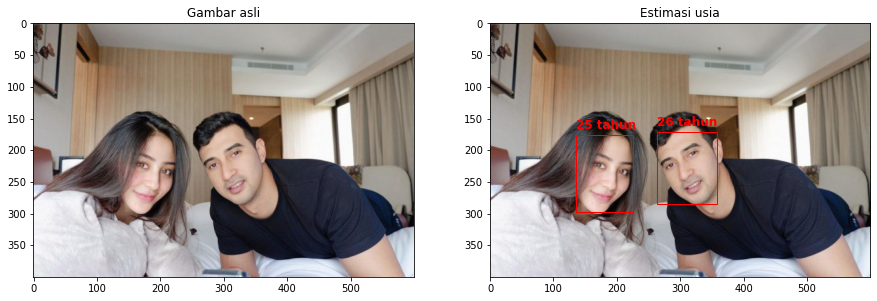

In [ ]:
age_predict(url = 'https://cdn.idntimes.com/content-images/community/2021/05/marginw-20210527-091614-0-763ebdc3f99752f83f98f5c7a3a7aa39-573a8cb0ad06d360d5dc66dcc74eaf00_600x400.jpg')

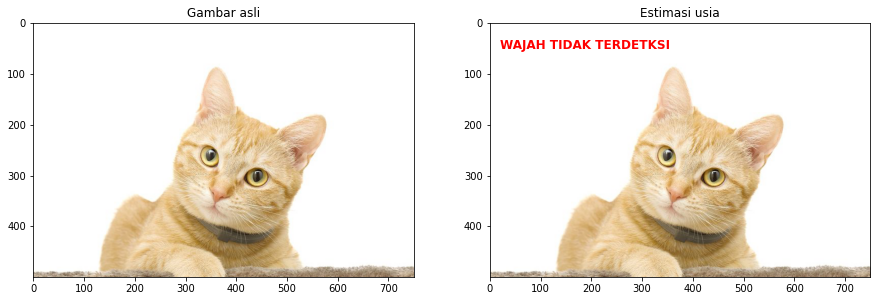

In [ ]:
age_predict(url = 'https://asset.kompas.com/crops/SV5q4gPkeD8YJTuzO31BqTr9DEI=/192x128:1728x1152/750x500/data/photo/2021/03/06/60436a28b258b.jpg')